In [2]:
# Load of principal libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [114]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# Load of datasets
batch_stats = pd.read_csv(r'D:/Juan/proyectos_personales/App_biotech/Data/100_Batches_IndPenSim_Statistics.csv')
production_data = pd.read_csv(r'D:/Juan/proyectos_personales/App_biotech/Data/100_Batches_IndPenSim_V3.csv')

In [4]:
# Summary of batch_stats
batch_stats.head(5) 

,Batch ref,Penicllin_harvested_during_batch(kg),Penicllin_harvested_end_of_batch (kg),Penicllin_yield_total (kg),Fault ref(0-NoFault 1-Fault)
0,1,1066400.0,1720000.0,2786400.0,0
1,2,985910.0,1340100.0,2326000.0,0
2,3,1416100.0,1259200.0,2675300.0,0
3,4,815700.0,1071000.0,1886700.0,0
4,5,1128500.0,2434400.0,3562900.0,0


In [5]:
# Summary of production_data
production_data.head(5)

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,210,209,208,207,206,205,204,203,202,201
0,0.2,30,100,8,0.0000,30.118,9.8335,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.4,30,100,8,0.0000,51.221,18.1550,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.6,30,100,8,0.0000,54.302,9.5982,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.8,30,100,8,0.0000,37.816,4.3395,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,1.0,30,100,8,0.5181,18.908,1.1045,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


The following split follows the presented in the original github notebook: https://github.com/StephenGoldie/indpensim-notebook/blob/master/IndPenSim_Summary_data_notebook_V3.ipynb

### Data processing

#### Split data into spectral and process data

In [15]:
variable_raman_data = np.split(production_data, [production_data.columns.get_loc("2400")], axis=1)
variable_data = variable_raman_data[0]
variable_data = variable_data.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)','Batch reference(Batch_ref:Batch ref)':'2-PAT control(PAT_ref:PAT ref)'})

d:\Programas\Anaconda\envs\proyectos_personales\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
raman_spectra = variable_raman_data[1]
batch_ref_df = variable_data[['Batch reference(Batch_ref:Batch ref)']]
raman_spectra_batch_id = pd.concat([batch_ref_df, raman_spectra], axis=1)

### Proposed analysis


The following analysis will be made:

First an analysis will be done to check which variables have the biggest impact in the production on penicilinin per batch and if there is any statistical difference between the batches control strategy (recipe driven, operator controlled or apc controlled). For this analysis the batches with faults will be discarted.

Second, with the information of the previous analysis a decision tree based algorithm will be trained to estimate what are the most important variables that predict the production of penicilinin and to corroborate the conclusions of the previous part. With this information a soft sensor model will be trained to estimate on online manner the production of penicilinin discriminating between the control strategy and a comparsion between different types of models like MLP, LSTM, XGBoost, and LightGBM will be made.

Thirdly a predictive maintenence model can be trained to predicte the faults using the faulty batches to complement the analysis.

### Batch's analysis

In [135]:
batch_analysis = variable_data.copy()
batch_analysis = variable_data[variable_data['Batch reference(Batch_ref:Batch ref)'] < 91]

In [137]:
batch_analysis.columns

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Agitator RPM(RPM:RPM)',
       'Sugar feed rate(Fs:L/h)', 'Acid flow rate(Fa:L/h)',
       'Base flow rate(Fb:L/h)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
       'Generated heat(Q:kJ)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'PAA flow(Fpaa:PAA flow (L/h))',
       'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
       'Oil flow(Foil:L/hr)',
       'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
       'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       'Offline Penicil

In [138]:
batch_analysis.dtypes

Time (h)                                                              float64
Aeration rate(Fg:L/h)                                                 float64
Agitator RPM(RPM:RPM)                                                 float64
Sugar feed rate(Fs:L/h)                                               float64
Acid flow rate(Fa:L/h)                                                float64
Base flow rate(Fb:L/h)                                                float64
Heating/cooling water flow rate(Fc:L/h)                               float64
Heating water flow rate(Fh:L/h)                                       float64
Water for injection/dilution(Fw:L/h)                                  float64
Air head pressure(pressure:bar)                                       float64
Dumped broth flow(Fremoved:L/h)                                       float64
Substrate concentration(S:g/L)                                        float64
Dissolved oxygen concentration(DO2:mg/L)                        

In [139]:
batch_analysis.describe()

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,Batch reference(Batch_ref:Batch ref),2-PAT control(PAT_ref:PAT ref),Batch ID,Fault flag
count,102410.000000,102410.000000,102410.0,102410.000000,102410.000000,102410.00000,102410.000000,102410.000000,102410.000000,102410.000000,...,102410.0,1854.000000,102410.0,102410.000000,102410.000000,102410.000000,102410.000000,102410.0,102410.000000,102410.000000
mean,114.634176,65.333708,100.0,77.084416,0.059197,62.90602,70.980538,19.723115,154.706572,0.945083,...,0.0,51.348884,0.0,0.335758,1.329069,45.327312,45.327312,0.0,91392.427146,91491.358393
std,66.954269,11.536763,0.0,25.577316,0.479524,44.37527,97.609491,45.448045,155.675140,0.134345,...,0.0,23.718694,0.0,0.472257,0.469878,25.907053,25.907053,0.0,48026.584559,48114.261569
min,0.200000,30.000000,100.0,8.000000,0.000000,0.00000,0.000100,0.000100,0.000000,0.600000,...,0.0,4.075800,0.0,0.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000
25%,57.000000,60.000000,100.0,72.000000,0.000000,38.57900,10.722250,0.000100,0.000000,0.900000,...,0.0,34.995750,0.0,0.000000,1.000000,23.000000,23.000000,0.0,48382.000000,48358.000000
50%,113.800000,65.000000,100.0,80.000000,0.000000,56.70000,33.110500,0.112385,100.000000,0.900000,...,0.0,53.196000,0.0,0.000000,1.000000,45.000000,45.000000,0.0,94017.500000,94133.000000
75%,170.800000,75.000000,100.0,90.000000,0.000000,77.00175,92.788750,11.205000,250.000000,1.100000,...,0.0,73.338000,0.0,1.000000,2.000000,68.000000,68.000000,0.0,131400.000000,131600.000000
max,290.000000,75.000000,100.0,150.000000,8.319400,225.00000,1279.300000,977.000000,500.000000,1.100000,...,0.0,91.962000,0.0,1.000000,2.000000,90.000000,90.000000,0.0,194630.000000,195340.000000


In [ ]:
def batch_graph(value_per_batch, average_per_batch):
    """This function takes the value of some specific variable per batch, graphs it and compares it with the average value of the variable

    Args:
        value_per_batch (_type_): 
        average_per_batch (_type_): _description_
    """    

In [140]:
# Time per batch
time_per_batch = batch_analysis.groupby('Batch reference(Batch_ref:Batch ref)')['Time (h)'].max()
average_time_per_batch = time_per_batch.mean()


In [104]:
sns.set(rc={'figure.figsize':(20,7)})

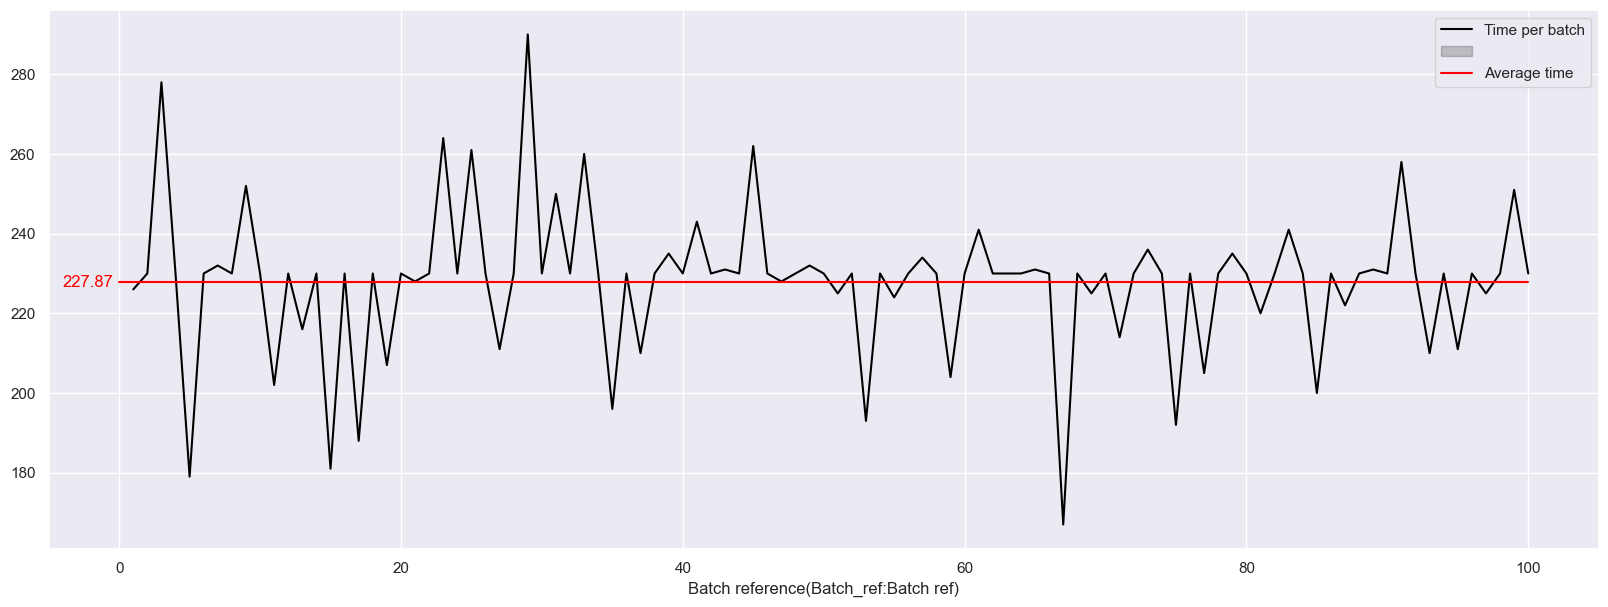

In [115]:
sns.lineplot(x = time_per_batch.index, y = time_per_batch.values, color = 'black')
sns.lineplot(x = range(0,101), y = average_time_per_batch, color = 'red')

plt.legend(labels = ['Time per batch', '', 'Average time'])
plt.text(-4, 226.5, average_time_per_batch, color = 'red')
plt.show()

In [132]:
# Penicilin production per batch
penicilin_batch = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Penicillin concentration(P:g/L)'].max()
average_penicilin_production = round(penicilin_batch.mean(), 2)


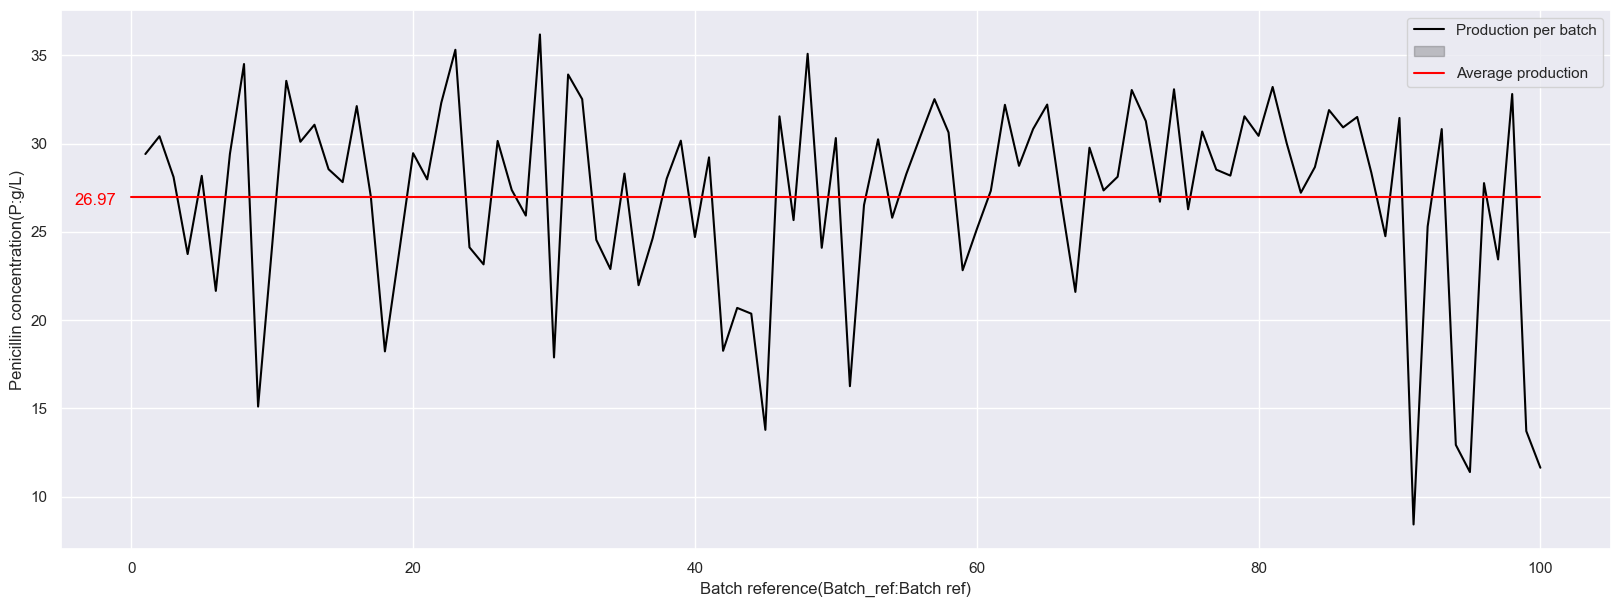

In [134]:
sns.lineplot(penicilin_batch, color = 'black')
sns.lineplot(x = range(0,101), y = average_penicilin_production, color = 'red')
plt.legend(labels = ['Production per batch', '', 'Average production'])
plt.text(-4, 26.5, average_penicilin_production, color = 'red')
plt.show()
plt.show()